# Deep Convolutional GAN (DCGAN) with SVHN

In this notebook, I use The **Street View House Numbers (SVHN) Dataset** [[1]](#ref1) to train DCGAN.  

If you are not familiar with GAN (Generative Adversarial Network), please see [gan_mnist.ipynb](gan_mnist.ipynb) that explains the concept in details using a simple network.  This notebook is a follow-up on that, and uses more convolutional networks for the generator and the discriminator.

The code is based on **Deep Convolutional GANs by Udacity** [[2]](#ref2).  Udacity uses TensorFlow but I use Keras on TensorFlow.

In [1]:
import numpy as np
from scipy.io import loadmat
import keras
import keras.backend as K
from keras.layers import Dense, Activation, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Loading SVHN Dataset

Download SVHN dataset from the Stanford website if not already done.

In [2]:
#
# Uncomment below to download SVHN datasets (it takes some time - a good time for a cup of coffee or two)
#
#!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
#!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

The data is in MATLAB format.  We use scipy's `loadmat` to load the data in numpy array.

In [3]:
train_data = loadmat('train_32x32.mat')
test_data  = loadmat('test_32x32.mat')

The `train_data` and `test_data` are `dict` object.  

They are the real images of house numbers but the shape is in (image_height, image_width, channels, records).

In [4]:
X_train, y_train = train_data['X'], train_data['y']
X_test,  y_test  = test_data['X'],  test_data['y']

X_train.shape

(32, 32, 3, 73257)

We roll the axis backward to make the shape to (records, image_height, image_width, channels).

In [5]:
# roll axis backward

X_train = np.rollaxis(X_train, 3)
X_test  = np.rollaxis(X_test, 3)

X_train.shape

(73257, 32, 32, 3)

Let's examine some sample images.

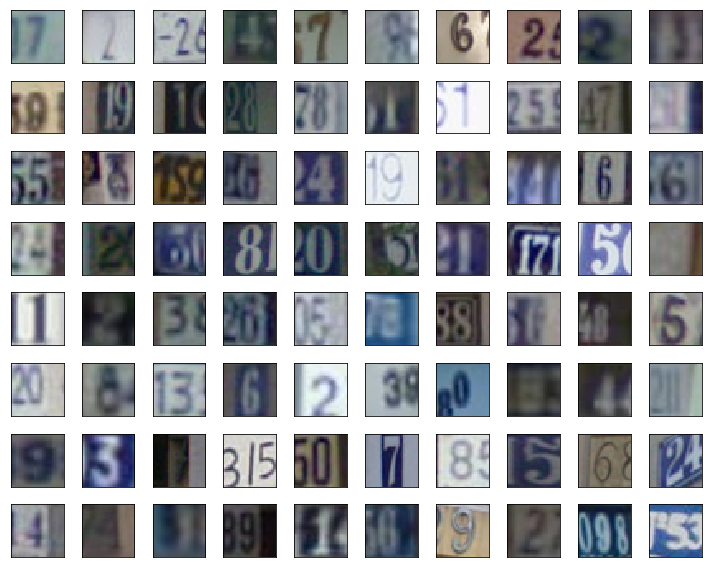

In [6]:
sample_images = X_train[np.random.choice(len(X_train), size=80, replace=False)]

plt.figure(figsize=(10, 8))
for i in range(80):
    plt.subplot(8, 10, i+1)
    plt.imshow(sample_images[i])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

## Preprocessing and Deprocessing

As usual, we need preprocessing and later deprocessing of the images.  

As we will see later on, the generator is using `tanh` activation, for which we need to preprocess the image data into the range between -1 and 1.

In [7]:
def preprocess(x):
    return (x/255)*2-1

def deprocess(x):
    return np.uint8((x+1)/2*255) # make sure to use uint8 type otherwise the image won't display properly

Apply the preprocessing on the train and test images (and they are the real images as oppose to the generated images).

In [8]:
X_train_real = preprocess(X_train)
X_test_real  = preprocess(X_test)

## Generator

The generator takes a latent sample (100 randomly generated numbers) and produces a 32x32 color image that should look like one from the SVHN dataset.

The original paper [[3]](#ref3) proposes the following generator network architecture.

<img src='../images/dcgan_svhn/generator.png' width='70%'>

Although the size of the images usedin the original paper is 64x64, the size of the images in SVHN is 32x32.  As such, I used smaller networks.

The generator takes a latent sample which has 100 random numbers.  It uses the fully connected layer to expand the dimension to $4 \times 4 \times 256$ neurons so that it can be reshaped into 4x4 2D shape with 512 filters.

After that, each layer's height and width are doubled by the transpose convolution and the filters are halved.  The last layer produces a 32x32 2D image with 3 channels.

The activation of the output layer is `tanh` which the discriminator expects.

In [9]:
def make_generator(input_size, leaky_alpha):
    # generates images in (32,32,3)
    return Sequential([
        Dense(4*4*512, input_shape=(input_size,)),
        Reshape(target_shape=(4, 4, 512)),                              # 4,4,512
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        Conv2DTranspose(256, kernel_size=5, strides=2, padding='same'), # 8,8,256
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'), # 16,16,128
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        Conv2DTranspose(3, kernel_size=5, strides=2, padding='same'),   # 32,32,3
        Activation('tanh')
    ])

## Discriminator


The discriminator is a classifier to tell if the input image is real or fake.  

It is a convolutional neural network that takes a 32x32 image with 3 channels.  The values in the image is expected to be between -1 and 1.

The activation of the output layer is `sigmoid` and the discriminator outputs a probability of the image being real.

In [10]:
def make_discriminator(leaky_alpha):
    # classifies images in (32,32,3)
    return Sequential([        
        Conv2D(64, kernel_size=5, strides=2, padding='same',     # 16,16,64
               input_shape=(32,32,3)),
        LeakyReLU(alpha=leaky_alpha),
        Conv2D(128, kernel_size=5, strides=2, padding='same'),   # 8,8,128
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        Conv2D(256, kernel_size=5, strides=2, padding='same'),   # 4,4,256
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        Flatten(),
        Dense(1),
        Activation('sigmoid')        
    ])

## DCGAN

We connect the generator and the discriminator to make a DCGAN.

The input to the DCGAN is a latent sample.  The generator inside DCGAN produces an image which is fed into the discriminator inside the DCGAN.  So, the output of DCGAN is the probability of the generated image being real.

In [11]:
# beta_1 is the exponential decay rate for the 1st moment estimates in Adam optimizer
def make_DCGAN(sample_size, 
               g_learning_rate, 
               g_beta_1,
               d_learning_rate,
               d_beta_1,
               leaky_alpha):
    # clear any session data
    K.clear_session()
    
    # generator
    generator = make_generator(sample_size, leaky_alpha)

    # discriminator
    discriminator = make_discriminator(leaky_alpha)
    discriminator.compile(optimizer=Adam(lr=d_learning_rate, beta_1=d_beta_1), loss='binary_crossentropy')
    
    # GAN
    gan = Sequential([generator, discriminator])
    gan.compile(optimizer=Adam(lr=g_learning_rate, beta_1=g_beta_1), loss='binary_crossentropy')
    
    return gan, generator, discriminator

## Training DCGAN

The below is a function to generate latent samples.

In [12]:
def make_latent_samples(n_samples, sample_size):
    #return np.random.uniform(-1, 1, size=(n_samples, sample_size))
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

The below is a function to set the discriminator to trainable or non-trainable.

In [13]:
def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

The below is a function to create a batch of labels.

In [14]:
def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])

This is to show a epoch - loss chart.

In [15]:
def show_losses(losses):
    losses = np.array(losses)
    
    fig, ax = plt.subplots()
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Validation Losses")
    plt.legend()
    plt.show()

This is to show generated images.

In [16]:
def show_images(generated_images):
    n_images = len(generated_images)
    cols = 10
    rows = n_images//cols
    
    plt.figure(figsize=(10, 8))
    for i in range(n_images):
        img = deprocess(generated_images[i])
        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

The training DCGAN is essentially the same as training a simple GAN in [gan_mnist.ipynb](gan_mnist.ipynb).

* set the discriminator trainable
* train the discriminator with real images with the label smoothing   (labels=1-smooth)
* train the discriminator with fake images generated by the generator (labels=0)
* set the discriminator non-trainable
* train the DCGAN with generated images (labels=1)

We repeat this process many times until the discriminator loss and the generator loss stabilizes.

In [17]:
def train(
    g_learning_rate, # learning rate for the generator
    g_beta_1,        # the exponential decay rate for the 1st moment estimates in Adam optimizer
    d_learning_rate, # learning rate for the discriminator
    d_beta_1,        # the exponential decay rate for the 1st moment estimates in Adam optimizer
    leaky_alpha,
    smooth=0.1,
    sample_size=100, # latent sample size (i.e. 100 random numbers)
    epochs=25,
    batch_size= 128, # train batch size
    eval_size=16,    # evaluate size
    show_details=True):
    
    # labels for the batch size and the test size
    y_train_real, y_train_fake = make_labels(batch_size)
    y_eval_real,  y_eval_fake  = make_labels(eval_size)

    # create a GAN, a generator and a discriminator
    gan, generator, discriminator = make_DCGAN(
        sample_size, 
        g_learning_rate, 
        g_beta_1,
        d_learning_rate,
        d_beta_1,
        leaky_alpha)

    losses = []
    for e in range(epochs):
        for i in range(len(X_train_real)//batch_size):
            # real SVHN digit images
            X_batch_real = X_train_real[i*batch_size:(i+1)*batch_size]

            # latent samples and the generated digit images
            latent_samples = make_latent_samples(batch_size, sample_size)
            X_batch_fake = generator.predict_on_batch(latent_samples)

            # train the discriminator to detect real and fake images
            make_trainable(discriminator, True)
            discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
            discriminator.train_on_batch(X_batch_fake, y_train_fake)

            # train the generator via GAN
            make_trainable(discriminator, False)
            gan.train_on_batch(latent_samples, y_train_real)

        # evaluate
        X_eval_real = X_test_real[np.random.choice(len(X_test_real), eval_size, replace=False)]

        latent_samples = make_latent_samples(eval_size, sample_size)
        X_eval_fake = generator.predict_on_batch(latent_samples)

        d_loss = discriminator.test_on_batch(X_eval_real, y_eval_real)
        d_loss = discriminator.test_on_batch(X_eval_fake, y_eval_fake)
        g_loss = gan.test_on_batch(latent_samples, y_eval_real) # we want the fake to be realistic!

        losses.append((d_loss, g_loss))

        print("Epoch: {:>3}/{} Discriminator Loss: {:>7.4f}  Generator Loss: {:>7.4f}".format(
            e+1, epochs, d_loss, g_loss))

        # show the generated images
        if (e+1) % 5 == 0:
            show_images(X_eval_fake[:10])
    
    if show_details:
        show_losses(losses)
        show_images(generator.predict(make_latent_samples(80, sample_size)))    
    return generator

### Training 1

Although, the generator and the discriminator in this project are not exactly the same as in the DCGAN paper [[3]](#ref3), I tried the following hyterparameters as per the paper (the quotes are from the paper):

* batch_size = 128

> All models were trained with mini-batch stochastic gradient descent (SGD) with a mini-batch size of 128. 

Note: I use the Adam optimizer [[4]](#ref4) instead of SGD (as per my gut feeling).

* alpha=0.2 in LeakyReLU

> In the LeakyReLU, the slope of the leak was set to 0.2 in all models.

* 0.0002 for the learning rate

> We found the suggested learning rate of 0.001, to be too high, using 0.0002 instead. 

* 0.5 for `beta_1` 

> we found leaving the momentum term β1 at the suggested value of 0.9 resulted in training oscillation and instability while reducing it to 0.5 helped stabilize training.

Note: `beta_1` is the exponential decay rate for the momentum term (an exponential average of weight gradients).  The momentum is the estimation of true gradients.  It is used to realize smoother weight updates by avoiding random spikes.

Epoch:   1/25 Discriminator Loss:  0.0000  Generator Loss: 16.1181
Epoch:   2/25 Discriminator Loss:  0.0000  Generator Loss: 15.6936
Epoch:   3/25 Discriminator Loss:  0.0000  Generator Loss: 11.4401
Epoch:   4/25 Discriminator Loss:  1.9293  Generator Loss:  0.1583
Epoch:   5/25 Discriminator Loss:  0.2582  Generator Loss:  1.6303


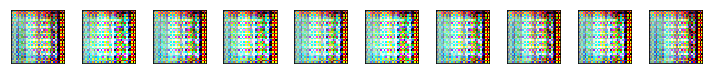

Epoch:   6/25 Discriminator Loss:  0.0000  Generator Loss: 11.7135
Epoch:   7/25 Discriminator Loss:  0.0000  Generator Loss: 10.5611
Epoch:   8/25 Discriminator Loss:  0.0001  Generator Loss:  9.5827
Epoch:   9/25 Discriminator Loss:  0.0001  Generator Loss:  8.8984
Epoch:  10/25 Discriminator Loss:  0.0004  Generator Loss:  7.8880


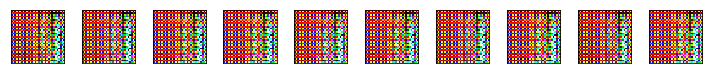

Epoch:  11/25 Discriminator Loss:  1.9307  Generator Loss:  0.1643
Epoch:  12/25 Discriminator Loss:  0.1486  Generator Loss:  2.0801
Epoch:  13/25 Discriminator Loss:  0.7701  Generator Loss:  0.6888
Epoch:  14/25 Discriminator Loss:  1.0041  Generator Loss:  0.5596
Epoch:  15/25 Discriminator Loss:  0.8030  Generator Loss:  0.7914


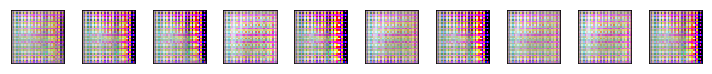

Epoch:  16/25 Discriminator Loss:  0.4943  Generator Loss:  0.9735
Epoch:  17/25 Discriminator Loss:  0.7078  Generator Loss:  1.4940
Epoch:  18/25 Discriminator Loss:  0.0009  Generator Loss:  9.1323
Epoch:  19/25 Discriminator Loss:  0.0051  Generator Loss:  6.4290
Epoch:  20/25 Discriminator Loss:  1.6127  Generator Loss:  0.2297


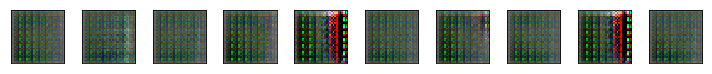

Epoch:  21/25 Discriminator Loss:  0.2363  Generator Loss:  1.6108
Epoch:  22/25 Discriminator Loss:  0.1047  Generator Loss:  2.3471
Epoch:  23/25 Discriminator Loss:  0.2488  Generator Loss:  1.6790
Epoch:  24/25 Discriminator Loss:  0.0001  Generator Loss:  9.9959
Epoch:  25/25 Discriminator Loss:  0.0002  Generator Loss:  8.8880


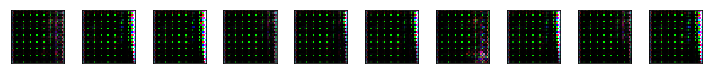

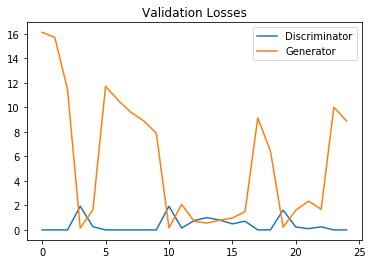

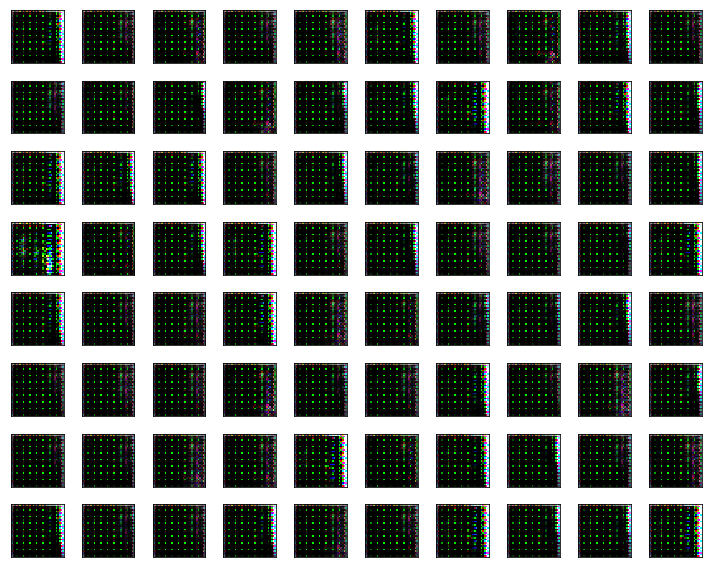

In [18]:
train(g_learning_rate=0.0002, g_beta_1=0.5, d_learning_rate=0.0002, d_beta_1=0.5, leaky_alpha=0.2);

### Training 1 Observations

* it produced garbage images oly.  
* the generator loss is oscillating.
* the discriminator loss is relatively stable.  

### Training 2

Let's reduce the generator learning rate and increase the discriminator's learning rate to see how it goes.

Epoch:   1/25 Discriminator Loss:  0.7984  Generator Loss:  0.6132
Epoch:   2/25 Discriminator Loss:  0.7610  Generator Loss:  0.8002
Epoch:   3/25 Discriminator Loss:  0.8515  Generator Loss:  0.7675
Epoch:   4/25 Discriminator Loss:  0.2270  Generator Loss:  1.8033
Epoch:   5/25 Discriminator Loss:  0.5289  Generator Loss:  1.3023


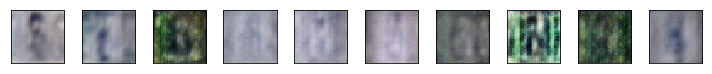

Epoch:   6/25 Discriminator Loss:  1.0098  Generator Loss:  0.5348
Epoch:   7/25 Discriminator Loss:  0.5266  Generator Loss:  1.1664
Epoch:   8/25 Discriminator Loss:  0.6705  Generator Loss:  0.8258
Epoch:   9/25 Discriminator Loss:  0.3354  Generator Loss:  1.4604
Epoch:  10/25 Discriminator Loss:  0.3701  Generator Loss:  1.4001


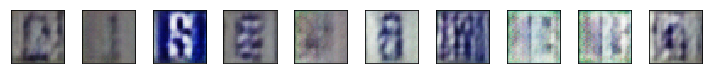

Epoch:  11/25 Discriminator Loss:  0.7519  Generator Loss:  0.7047
Epoch:  12/25 Discriminator Loss:  0.6715  Generator Loss:  1.2331
Epoch:  13/25 Discriminator Loss:  0.2881  Generator Loss:  1.5134
Epoch:  14/25 Discriminator Loss:  0.4390  Generator Loss:  1.2028
Epoch:  15/25 Discriminator Loss:  0.2614  Generator Loss:  1.6220


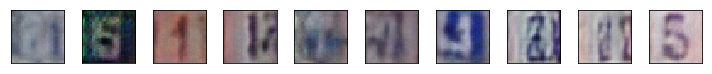

Epoch:  16/25 Discriminator Loss:  0.0950  Generator Loss:  2.4596
Epoch:  17/25 Discriminator Loss:  0.3719  Generator Loss:  1.3201
Epoch:  18/25 Discriminator Loss:  0.4173  Generator Loss:  1.2475
Epoch:  19/25 Discriminator Loss:  0.2443  Generator Loss:  2.1294
Epoch:  20/25 Discriminator Loss:  0.2593  Generator Loss:  1.8458


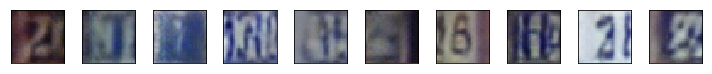

Epoch:  21/25 Discriminator Loss:  0.1846  Generator Loss:  2.1402
Epoch:  22/25 Discriminator Loss:  0.3141  Generator Loss:  1.5387
Epoch:  23/25 Discriminator Loss:  0.3172  Generator Loss:  1.7587
Epoch:  24/25 Discriminator Loss:  0.3155  Generator Loss:  1.8563
Epoch:  25/25 Discriminator Loss:  0.1733  Generator Loss:  2.2446


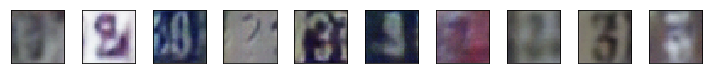

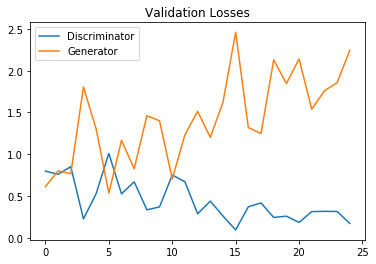

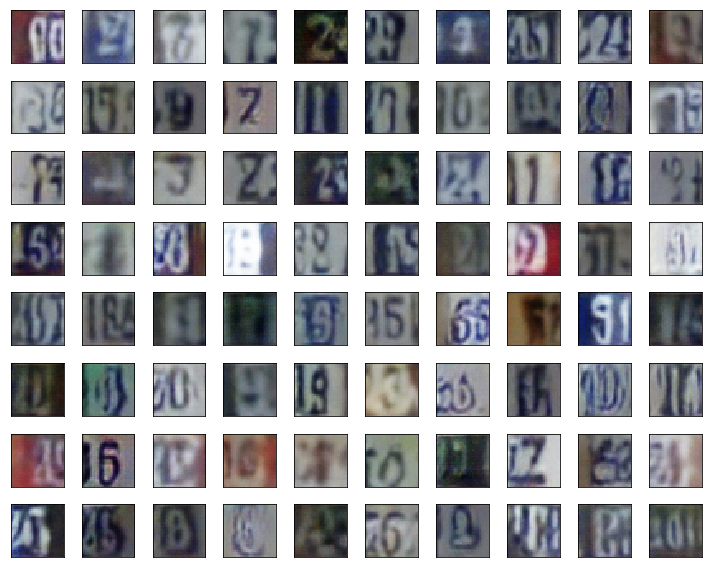

In [19]:
train(g_learning_rate=0.0001, g_beta_1=0.5, d_learning_rate=0.001, d_beta_1=0.5, leaky_alpha=0.2);

### Training 2 Observations

* It does generate house numbers.  Much better than the training 1.
* The generator loss goes up gradually - bad.
* The discriminator loss goes down gradually - good.

### Training 3

The training 2 is much better than the training 1.  What else can I try?  How about setting the beta_1 to the default value of 0.9?

Epoch:   1/25 Discriminator Loss:  0.9240  Generator Loss:  0.5198
Epoch:   2/25 Discriminator Loss:  1.7228  Generator Loss:  0.2827
Epoch:   3/25 Discriminator Loss:  1.3021  Generator Loss:  0.5040
Epoch:   4/25 Discriminator Loss:  0.4413  Generator Loss:  1.6586
Epoch:   5/25 Discriminator Loss:  0.1911  Generator Loss:  1.9182


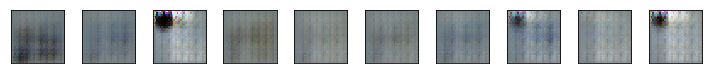

Epoch:   6/25 Discriminator Loss:  0.7027  Generator Loss:  0.7142
Epoch:   7/25 Discriminator Loss:  0.1149  Generator Loss:  2.4194
Epoch:   8/25 Discriminator Loss:  0.2951  Generator Loss:  1.5130
Epoch:   9/25 Discriminator Loss:  0.0598  Generator Loss:  2.9814
Epoch:  10/25 Discriminator Loss:  0.1775  Generator Loss:  1.9603


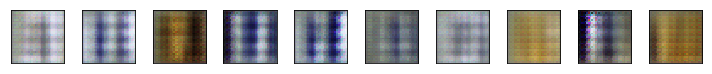

Epoch:  11/25 Discriminator Loss:  0.1760  Generator Loss:  2.2707
Epoch:  12/25 Discriminator Loss:  0.1571  Generator Loss:  2.3178
Epoch:  13/25 Discriminator Loss:  0.1047  Generator Loss:  2.8370
Epoch:  14/25 Discriminator Loss:  0.0939  Generator Loss:  2.8119
Epoch:  15/25 Discriminator Loss:  0.1126  Generator Loss:  2.4662


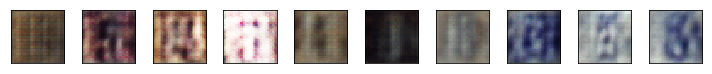

Epoch:  16/25 Discriminator Loss:  0.1916  Generator Loss:  2.1378
Epoch:  17/25 Discriminator Loss:  0.3127  Generator Loss:  1.9406
Epoch:  18/25 Discriminator Loss:  0.1136  Generator Loss:  2.5518
Epoch:  19/25 Discriminator Loss:  0.1009  Generator Loss:  2.4722
Epoch:  20/25 Discriminator Loss:  0.1117  Generator Loss:  2.4643


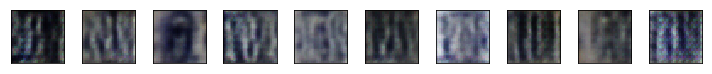

Epoch:  21/25 Discriminator Loss:  0.0996  Generator Loss:  2.7817
Epoch:  22/25 Discriminator Loss:  0.1413  Generator Loss:  2.4212
Epoch:  23/25 Discriminator Loss:  0.0947  Generator Loss:  2.6265
Epoch:  24/25 Discriminator Loss:  0.1495  Generator Loss:  2.2819
Epoch:  25/25 Discriminator Loss:  0.1345  Generator Loss:  2.7094


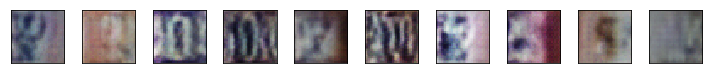

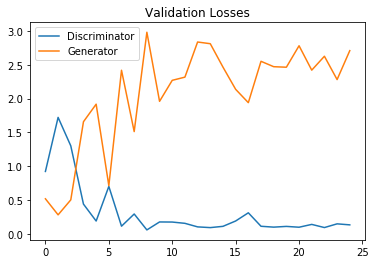

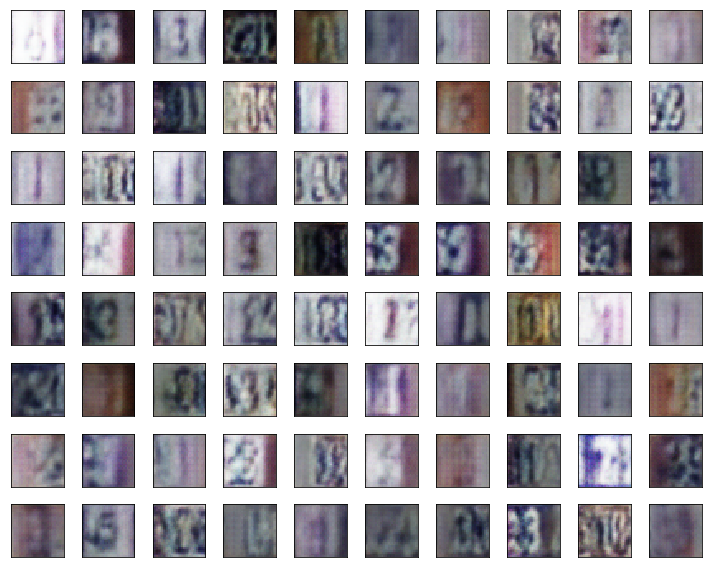

In [20]:
train(g_learning_rate=0.0001, g_beta_1=0.9, d_learning_rate=0.001, d_beta_1=0.9, leaky_alpha=0.2);

### Training 3 Observations

* The generated images look worse than the training 2
* The generator loss goes up and stay high
* The discriminator loss goes down and stays low

## Conclusion

* GANs in general is notoriously hard to train. This project is also not easy in that aspect.
* Overall, the training 2 performed the best in terms of realness of the generated images.
* More hyperparameter tuning should be experimented if we want to improve further.

## References

<a id="ref1"></a>
### [1] The Street View House Numbers (SVHN) Dataset

Stanford

http://ufldl.stanford.edu/housenumbers/

<a id="ref2"></a>
### [2] Deep Convolutional GANs

Udacity

https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb

<a id="ref3"></a>
### [3] Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks

Alec Radford & Luke Metz (indico Research), Soumith Chintala (Facebook AI Research)

https://arxiv.org/pdf/1511.06434.pdf

<a id="ref4"></a>
### [4] ADAM: A Method for Stocastic Optimization

Diederik P. Kingma (University of Amsterdam, OpenAI), Jimmy Lei Ba (University of Toronto)

https://arxiv.org/pdf/1412.6980.pdf